# Visualization of clustering

**Content:**
  * Introduction
  * Data Preparation
  * Calculation of the clusters
  * Data Aggregation
  * Visualization and Conclusion
  
----------------------------------------------------------------------------------------------------------------------------

## Introduction
In this notebook, I'd like to show you my favourite way of visualizing clusters from an arbitrary clustering algorithm. I will work with the telco customer churn dataset. Note that the sole purpose of this notebook is to visualize the clustered data, hence I will omit analysis of the data or finding the best clustering algorithm and the number of clusters.

Below is a list of columns, their description and a column type:
  * **Area Code2**:	Area where the customer lives, nominal multilevel
  * **Intl Plan**:	Does the customer have an international plan, nominal binary
  * **Vmail**:	Does the customer use voicemail, nominal binary
  * **Vmail Message**:	How many voicemail messages per month, numeric
  * **Day Mins**:	How many minutes per month does the customer call during daytime, numeric
  * **Day Calls**:	How many calls does the customer make during daytime, numeric
  * **Day Charge**:	How much is the customer charged for calls during daytime, numeric
  * **Eve Mins**:	How many minutes per month does the customer call during evening, numeric
  * **Eve Calls**:	How many calls does the customer make during evening, numeric
  * **Eve Charge**:	How much is the customer charged for calls during evening, numeric
  * **Night Mins**:	How many minutes per month does the customer call during night, numeric
  * **Night Calls**:	How many calls does the customer make during night, numeric
  * **Night Charge**:	How much is the customer charged for calls during night, numeric
  * **Intl Mins**:	How many minutes per month does the customer call to international numbers, numeric
  * **Intl Calls**:	How many international calls does the customer make, numeric
  * **Intl Charge**:	How much is the customer charged for international calls, numeric
  * **CustServ Calls**:	How many times did the customer contact customer service	, umeric
  * **Churn**:	Did the customer churn in the next period, nominal binary target


In [1]:
#Imports
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import zscore
from matplotlib import pyplot as plt
from sklearn import preprocessing as prep
import seaborn as sns

#Print Options
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=100, precision=4,suppress=True)

headers = ['Area Code2','Intl Plan','Vmail','Vmail Message','Day Mins',
           'Day Calls','Day Charge','Eve Mins','Eve Calls','Eve Charge',
           'Night Mins','Night Calls','Night Charge','Intl Mins',
           'Intl Calls','Intl Charge','CustServ Calls','Churn']

df_churn = pd.read_csv('C:/Users/Honza/Desktop/Projects/heatmap/churn.csv', sep=',')
df_churn.columns = headers

height has been deprecated.



## Data Preparation
We start with little cleaning of the data and look a bit at the structure. Note that I will not work with Area Code, because the method I am using is based on averaging the data and the variable is categorical. Moreover, we do not want the target class leak into the clustering solution, hence the class is not used in the calculation of the clusters.

I also attached a small statistic about the dataset.

In [2]:
#Trim white space in the headers
df_churn = df_churn.rename(columns=lambda x: x.strip())

#Store clmn names in a list except the target variable
clmns = list(df_churn.columns.values)
clmns.remove('Churn')
clmns.remove('Area Code2')

#Check for missing values
print 'Are there any missing values? {}'.format(df_churn.isnull().values.any())
print '\n'

#Let's have a look at the data
print df_churn.ix[:5,0:10].head(n=5)
print '\n'
print df_churn.ix[:5,11:18].head(n=5)
print '\n'
print 'The size of the dataset is {}'.format(len(df_churn))
print '\n'
print 'Structure of churners:'
print df_churn.groupby('Churn')['Churn'].count()
print '\n'
print 'The dataset contains {}% of churners'.format(df_churn.groupby('Churn')['Churn'].count()[1]/float(len(df_churn))*100)

Are there any missing values? False


   Area Code2  Intl Plan  Vmail  Vmail Message  Day Mins  Day Calls  Day Charge  Eve Mins  Eve Calls  Eve Charge
0           1          0      0             37     239.8        110       40.77     66.57         12       18.86
1           2          0      1              0     223.2        109       37.94     38.25          9       10.84
2           1          0      1              0     217.1         99       36.91     70.80          7       20.06
3           1          0      1              0     159.7         83       27.15     46.62         12       13.21
4           0          0      1              0     204.6         98       34.78     63.75          9       18.06


   Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  CustServ Calls  Churn
0           10          8.51        7.3           1         1.97               2      0
1            8         13.02       14.5           4         3.92               3      0
2           12    

## Calculate the clusters
For the sake of the exercise, I will skip choosing and fine tunning the clustering algorithm and simply use out-of-box k-Means from sklearn. I have chosen three clusters, because it gives us nice visible differences between the clusters.

Because k-Means uses Euclidian distance, the data are normalized using z-score (I found out that z-score gives overall the most stable solution). We can argue that boolean data are not really suitable for k-Means, but since there are only two binary columns and the main goal is not to find best clusters, I will ignore this for now.

In [3]:
#########
n_cls = 3
#########

def clusterer(df_,k):
    '''
    Calculates cluster labels in the dataset
    -------------------------------------------
    df_: DataFrame containing the training data
    k: number of clusters
    -------------------------------------------
    '''
    #Normalize
    df_std = df_.apply(zscore).as_matrix()
    #Fit the algorithm
    cluster = KMeans(n_clusters=k)
    cluster_labels = cluster.fit_predict(df_std)
    return cluster_labels 

df_churn['clusters'] = clusterer(df_churn[clmns],n_cls)

## Data Aggregation
Now the interesting part. Every record has a cluster label. In this step, I calculate the mean over each column for each cluster. Moreover, I also add the mean of each column from the whole sample - this will serve as a benchmark.

In [4]:
def calcClusterFrame(df_, clmn, target_name):
    '''
    Calculates mean for each attribute in each cluster group in order to be easily comparable.
    Moreover, average in the whole sample is added as a benchmark
    -------------------------------------------
    clmn: list of columns
    target_name: name of target column
    df_: DataFrame with input data
    ----------------------------------------'''
    #Calculates mean over all samples
    clmns1 = list(clmn)  
    clmns1.extend([target_name])
    df_sample = pd.DataFrame()
    df_sample['sample_val'] = df_[clmns1].mean(axis=0)
    
    #Calculates mean per cluster
    clmns2 = list(clmns1) 
    clmns2.extend(['clusters'])
    df_clusters = df_[clmns2].groupby(['clusters']).mean().transpose()
    
    #Size of clusters in percentage
    df_clusters.loc['SIZE'] = (df_[clmns2].groupby('clusters')['clusters'].count()/len(df_))*100
    
    #Merge the two DataFrames into one and round
    df_analysis = pd.concat([df_sample['sample_val'],df_clusters], axis=1, join='outer').round(2)
    
    #Set column names
    clmn_names = ['sample_val']
    for clus in np.unique(df_['clusters']):
        clmn_names.append('Cluster_' + str(clus))
        
    df_analysis.columns = clmn_names
    
    #Add count of the whole sample
    df_analysis.loc['SIZE', 'sample_val'] = len(df_)
    
    return df_analysis

If you look at the output, you can easily see the differences between the clusters. I have also added size of the whole sample and of each cluster (in percentage). 

In [5]:
df_agg = calcClusterFrame(df_churn, clmns, 'Churn')
print df_agg

                sample_val  Cluster_0  Cluster_1  Cluster_2
Churn                 0.14       0.13       0.19       0.08
CustServ Calls        1.57       1.54       1.62       1.54
Day Calls           100.03      99.81     100.33      99.91
Day Charge           30.65      25.63      35.61      30.74
Day Mins            180.29     150.78     209.45     180.84
Eve Calls            10.07      10.02      10.13      10.06
Eve Charge           17.05      18.38      15.62      17.20
Eve Mins             60.19      64.87      55.13      60.71
Intl Calls            4.44       4.44       4.44       4.41
Intl Charge           2.77       3.07       2.47       2.77
Intl Mins            10.26      11.38       9.13      10.28
Intl Plan             0.09       0.10       0.09       0.10
Night Calls          10.04       9.98      10.07      10.07
Night Charge          9.02       8.24       9.78       9.04
Night Mins           20.04      18.30      21.74      20.09
SIZE               5000.00      36.90   

## Visualization and conclusion
We have the aggregated table, which does the job, but you would not show this to your boss (I hope). We need to put some fancy colors and make it good-looking!

Just a few notes:
  * argument *prc_clmn* allows to format certain columns as a percentage. This can be useful if any of the input feature is boolean, because then the average is in fact a percentage
  * I also added arguments *dire* and *size*, because sometimes I want to visualize different kinds of DataFrames. Those two parameters allow the function to be more flexible

In [6]:
def clusterHeatMap(df, clmn, prc_clmn, dire='column', width='5', length='5', color='Blues', size=False):
    """Plot a heatmap from the aggregated dataframe
    --------------------------------------------------------------
    df: Aggregated DataFrame to be visualized
    clmn: list of columns (in case i need to rename them or make them more readable)
    prc_clmn: list of columns which should be formatted as a percentage. If none, put []
    dire: how the standardization should be - per row or column
    width and length: width and length of the plot
    color: What kind of color I want, its cmap argument in seaborn, so many colors are possible
    size: whether SIZE row is present and should be formatted
    --------------------------------------------------------------"""
    #Scale the data to have the heatmap 
    scaler = prep.MinMaxScaler()
    mat = df.as_matrix()
    
    if dire =='row':
        scale_t = scaler.fit_transform(mat.T).T
    if dire == 'column':
        scale_t = scaler.fit_transform(mat)
        
    df_std = pd.DataFrame(scale_t, columns=list(df.columns.values), index=df.index)
    
    #Percentage formatting    
    # get positions of columns to be converted to percentage
    idx_position = []
    if prc_clmn:
        for col in prc_clmn:
            try:
                idx_position.append(df.index.get_loc(col))
            except:
                print 'Column {} is not in the DataFrame'.format(col)
    
    # format every row depending whether it should be % or not        
    labels_char = []
    for rowid,row in enumerate(mat):
        aux = []
        for ele in row:
            if rowid in idx_position:
                aux.append('{:.2f}%'.format(ele*100))
            else:
                aux.append('{:.2f}'.format(ele))
        labels_char.append(aux)
    
    #Format SIZE for cluster heatmaps
    idx = df.index.tolist()
    if size:
        position = idx.index('SIZE')
        for i,ele in enumerate(labels_char[position]):
            if i > 0:
                labels_char[0][i] = '{:.2f}%'.format(np.float(ele))
        
    #needs to be in numpy in order to pass it as a parameter to seaborn
    labels_char = np.array(labels_char)
            
    #Plot and its formatting
    fig, ax = plt.subplots(figsize=(width,length))
    ax = sns.heatmap(df_std, annot=labels_char, fmt = '', cmap=color) #fmt must be set to '' when working with str
    ax.set_xticklabels(clmn, minor=False)
    ax.xaxis.tick_top() #move on top

Below you can see the visualization. I told the function that there are three columns which are boleans and hence can be formatted as a percentage. Moreover, I changed the order of the rows, because usually the target variable and size are the first information one needs to have.

I really like this because with a quick look, I can tell:

  1. size of each group
  2. difference between the attributes in the clusters
  3. comparison with the whole dataset
  4. where the churners are


**With detailed look, I can tell that:**
  * **Cluster_0** appears to be customers with average probability of churn. Interestingly, this group have above average usage of international calls (Intl Mins, Calls and Charge). Thus, this can be leveraged when making personalized campaigns.
  * **Cluster_1** contains above average number of churners. Those people make the most calls during the day and night (Day/Night Mins, Charge and Calls) and use often the customer service (CustServ Calls). Therefore, we can say that the more the user is using the services, the more he/she is susceptible to leave. One of the explanations could be that for those customers, the calling is somewhat important, hence are willing to leave for better price or services.
  * **Cluster_2** seems to represent the loyal customers (churn rate is almost half less). Judging the colors, these customers have average values of most of the attributes. This group is also the smallest.
  
To conclude, this aggregated heatmap can actually give a lot of information, while being easy to understand and simple. I also like to show this to the business colleagues, who can add deeper insights from the business side. In case the data are categorical, we can replace the mean by mode. I recommend to wrap this into one fuction and store in a library, where you can have this by few lines of code.
 

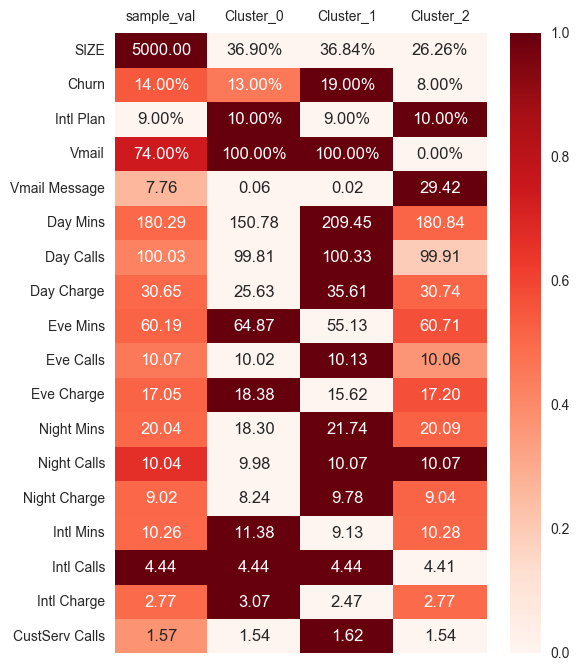

In [7]:
#Columns to be formatted as percentage
clmns_prc = ['Intl Plan','Vmail', 'Churn']

#Reorder rows
clmns_ordered = ['SIZE','Churn','Intl Plan','Vmail','Vmail Message','Day Mins',
                 'Day Calls','Day Charge','Eve Mins','Eve Calls','Eve Charge',
                 'Night Mins','Night Calls','Night Charge','Intl Mins',
                 'Intl Calls','Intl Charge','CustServ Calls']

df_agg = df_agg.reindex(index=clmns_ordered)

clusterHeatMap(df_agg, df_agg.columns, clmns_prc, dire='row', width=6, length=8, color='Reds', size=True)
plt.show();